In [1]:
# Imports
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

2025-08-17 11:19:43.519752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755429583.717869      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755429583.778476      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Giving Path to Data Directories
base_dir = '/kaggle/input/silicosis-order/gendata'
train_dir = os.path.join(base_dir, 'train')
test_dir  = os.path.join(base_dir, 'test')

# Image Parameters
img_size = (224, 224)
batch_size = 32

In [3]:
import cv2
import numpy as np

def clahe_preprocess(img):
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    # Apply CLAHE only to L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    # Merge channels back
    lab = cv2.merge((l, a, b))
    # Convert LAB → RGB
    img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    # Convert to float32 (Keras requirement) and normalize [0,1]
    img_clahe = img_clahe.astype(np.float32) / 255.0

    return img_clahe

In [16]:
train_datagen = ImageDataGenerator(
    preprocessing_function=clahe_preprocess,
    height_shift_range=0.05,
    width_shift_range=0.02,
    rotation_range=0.3,
    shear_range=0.01,
    fill_mode='nearest',
    zoom_range=0.05,
    validation_split=0.20  # 20% for validation
)

test_datagen = ImageDataGenerator(preprocessing_function=clahe_preprocess)

# Training generator (80%)
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # set to training subset
)

# Validation generator (20%)
val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  
)

# Test generator
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    class_mode='binary',
    shuffle=False
)


Found 507 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [5]:
# Load Your Previously Trained Model
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
# Load the full TB model
#pretrained_model = load_model('/kaggle/input/pretrained-model/VGG16_TB_model.keras')
pre_trained_model = VGG19(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)
#  Print layer names to identify the one before the output
pre_trained_model.summary()

I0000 00:00:1755429597.307964      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

def build_model():
    feature_output = pre_trained_model.output

    x = GlobalAveragePooling2D()(feature_output)
    x = BatchNormalization()(x)  
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)  
    x = Dropout(0.3)(x)
    x = Dense(64, activation='softplus')(x)
    x = Dropout(0.25)(x)
    x = Dense(1, activation='sigmoid')(x)  

    model = Model(inputs=pre_trained_model.input, outputs=x)
    return model

In [7]:
# Freeze All Layers from Pretrained Model
pre_trained_model.trainable = False


In [8]:
from keras.src import ops
from keras.src.api_export import keras_export
from keras.src.optimizers import optimizer
import tensorflow as tf
import math

@keras_export("keras.optimizers.FSGD")
class FSGD(optimizer.Optimizer):
    """Fractional Gradient Descent (FSGD) optimizer."""

    def __init__(
        self,
        learning_rate=0.0001,
        alpha=1.2,
        epsilon=1e-3,
        weight_decay=None,
        clipnorm=None,
        clipvalue=None,
        global_clipnorm=None,
        use_ema=False,
        ema_overwrite_frequency=None,
        loss_scale_factor=None,
        gradient_accumulation_steps=None,
        name="FSGD",
        **kwargs,
    ):
        super().__init__(
            learning_rate=learning_rate,
            name=name,
            weight_decay=weight_decay,
            clipnorm=clipnorm,
            clipvalue=clipvalue,
            global_clipnorm=global_clipnorm,
            use_ema=use_ema,
            ema_overwrite_frequency=ema_overwrite_frequency,
            loss_scale_factor=loss_scale_factor,
            gradient_accumulation_steps=gradient_accumulation_steps,
            **kwargs,
        )
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma_val = math.gamma(2 - self.alpha)

    def build(self, variables):
        if self.built:
            return
        super().build(variables)
        self.previous_variables = [
            self.add_variable_from_reference(var, name="prev_weight")
            for var in variables
        ]

    def update_step(self, gradient, variable, learning_rate):
        learning_rate = ops.cast(learning_rate, variable.dtype)
        gradient = ops.cast(gradient, variable.dtype)
        alpha = ops.cast(self.alpha, variable.dtype)
        epsilon = ops.cast(self.epsilon, variable.dtype)
        gamma_val = ops.cast(self.gamma_val, variable.dtype)

        prev_var = self.previous_variables[self._get_variable_index(variable)]
        diff = ops.abs(variable - prev_var + epsilon)
        fractional_update = gradient * tf.pow(diff, 1 - alpha) / gamma_val

        self.assign_sub(variable, learning_rate * fractional_update)
        self.assign(prev_var, variable)

    def get_config(self):
        config = super().get_config()
        config.update({
            "alpha": self.alpha,
            "epsilon": self.epsilon,
        })
        return config

FSGD.__doc__ = FSGD.__doc__.replace(
    "{{base_optimizer_keyword_args}}", optimizer.base_optimizer_keyword_args
)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Ensure directory exists
os.makedirs("classification", exist_ok=True)

# List of alpha values
alphas = [1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9]
# Store training history for analysis
history_list = []

for alpha in alphas:
    model = build_model()
    
    steps_per_epoch = 20  # Given
    EPOCHS = 40
    decay_steps = steps_per_epoch * EPOCHS  # Compute decay steps
    
    #lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    #initial_learning_rate=1e-2,
    #decay_steps=decay_steps,
    #decay_rate=0.6)
    # Initialize the optimizer with the current alpha value
    optimizer = FSGD(
        learning_rate=0.001,
        alpha=alpha)
    
    def scheduler(epoch, lr):
        return lr * 0.6 if epoch % 10 == 0 else lr
    weight_path = f"classification/Silicosis_model_{alpha}.keras"
    lr_callback = keras.callbacks.LearningRateScheduler(scheduler)
    checkpoint = ModelCheckpoint(
        weight_path, monitor='val_loss', verbose=1,
        save_best_only=True, mode='min', save_weights_only=False
    )

    reduceLROnPlat = ReduceLROnPlateau(
        monitor='val_loss', factor=0.2,
        patience=20, verbose=1, mode='min',
        min_delta=0.00001, cooldown=5, 
        min_lr=0.000001
    )


    early = EarlyStopping(monitor="val_loss", mode="min", patience=40)
    callbacks_list = [checkpoint, early, reduceLROnPlat]

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    
    # Ensure generators are properly reset
    if hasattr(train_gen, "reset"):
        train_gen.reset()
    if hasattr(val_gen, "reset"):
        val_gen.reset()
    
    # Train the model
    history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    #class_weight=class_weights,
    callbacks=callbacks_list

    )

    history_list.append(history)

    # Load best weights before saving full model
    if os.path.exists(weight_path):
        print(f"Loading best weights for alpha={alpha}")
        model.load_weights(weight_path)
    else:
        print(f"Warning: {weight_path} not found! Skipping weight loading.")

    # Save full model
    model_save_path = f"fracmodel_alpha_{alpha}.h5"
    model.save(model_save_path)
    print(f"Model saved: {model_save_path}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


I0000 00:00:1755429610.025758     118 service.cc:148] XLA service 0x78620c013500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755429610.026838     118 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755429610.675653     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/16 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.5391 - loss: 1.0952 

I0000 00:00:1755429619.661291     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5516 - loss: 1.0206
Epoch 1: val_loss improved from inf to 0.69325, saving model to classification/Silicosis_model_1.0.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.5518 - loss: 1.0181 - val_accuracy: 0.5000 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.5314 - loss: 0.9650
Epoch 2: val_loss improved from 0.69325 to 0.68117, saving model to classification/Silicosis_model_1.0.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5321 - loss: 0.9634 - val_accuracy: 0.5000 - val_loss: 0.6812 - learning_rate: 0.0010
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - accuracy: 0.5634 - loss: 0.8418
Epoch 3: val_loss improved from 0.68117 to 0.66985, saving model to classification/Silicosis_model_1.0.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5633 - loss: 0.8438 - val_accuracy: 0.5794 - val_loss: 0.6698 - learning_rate: 0.0010
Epoch 4/40
16/16

In [10]:
from tensorflow.keras.models import load_model

# Fine-tuning parameters
fine_tune_lr = 1e-5    # Lower LR is common for fine-tuning

# To store fine-tuning histories
fine_tune_history_list = []

for alpha in alphas:
    print(f"\n Fine-tuning for alpha={alpha} ...")

    # Load the saved model
    model_path = f"fracmodel_alpha_{alpha}.h5"
    model = load_model(model_path, compile = False)

    # Freeze first 5 layers
    for layer in model.layers[:15]:
        layer.trainable = False

    # Unfreeze remaining layers
    for layer in model.layers[15:]:
        layer.trainable = True

    # Confirm the trainable status
    for i, layer in enumerate(model.layers):
        #print(f"Layer {i}: {layer.name} - Trainable: {layer.trainable}")

    # Recompile with a low LR for fine-tuning
    # If you use your custom FSGD, adjust accordingly:
     optimizer = FSGD(
        learning_rate=fine_tune_lr,
        alpha=alpha)

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    # Callbacks for fine-tuning
    weight_path = f"classification/finetune_{alpha}.keras"
    checkpoint = ModelCheckpoint(
        weight_path, monitor='val_loss', verbose=1,
        save_best_only=True, mode='min', save_weights_only=False
    )

    earlystop = EarlyStopping(
        monitor="val_loss", mode="min", patience=10, restore_best_weights=True
    )

    callbacks_list = [checkpoint, earlystop]

    # Reset generators (optional if needed)
    if hasattr(train_gen, "reset"):
        train_gen.reset()
    if hasattr(val_gen, "reset"):
        val_gen.reset()

    # Fine-tune the model
     # Fine-tune the model
    history_fine = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs=50,
    initial_epoch=history.epoch[-1],
    callbacks=callbacks_list
      )
    fine_tune_history_list.append( history_fine)

    



 Fine-tuning for alpha=1.0 ...
Epoch 40/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.7493 - loss: 0.5477
Epoch 40: val_loss improved from inf to 0.38573, saving model to classification/finetune_1.0.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7504 - loss: 0.5451 - val_accuracy: 0.8016 - val_loss: 0.3857
Epoch 41/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.7304 - loss: 0.5406
Epoch 41: val_loss did not improve from 0.38573
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7324 - loss: 0.5386 - val_accuracy: 0.8254 - val_loss: 0.3982
Epoch 42/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.7829 - loss: 0.4987
Epoch 42: val_loss improved from 0.38573 to 0.38085, saving model to classification/finetune_1.0.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7835 - loss: 0.4965 - val_accuracy: 0.8333 - val_loss: 0.3809
Epoch 43/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.7783 - loss: 0.4875
Epoch 43: val_loss did no

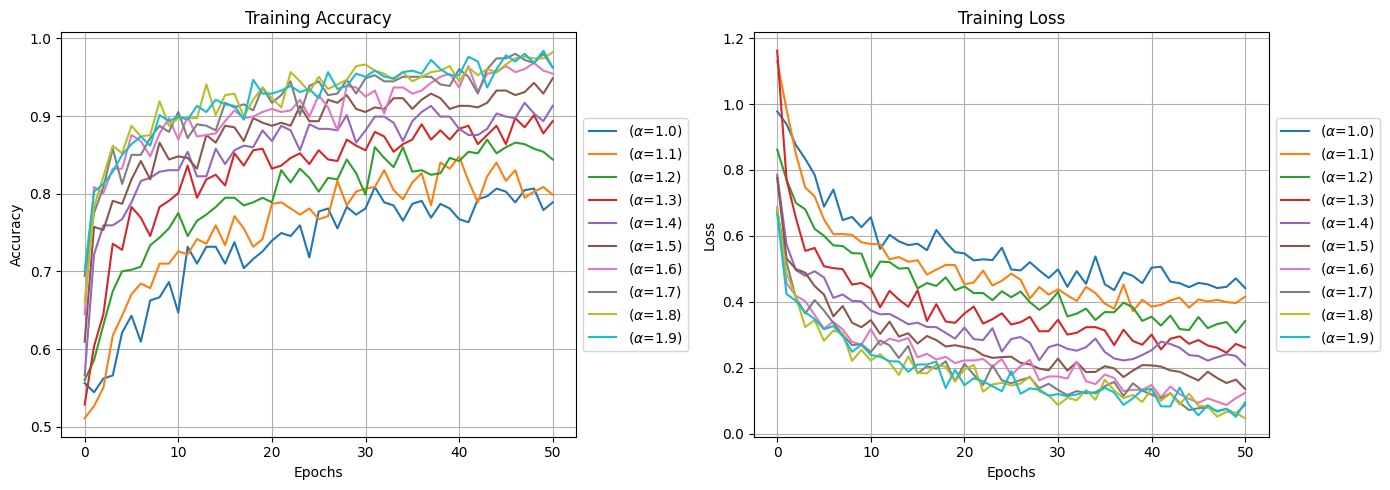

In [11]:
import matplotlib.pyplot as plt

# Create a figure with 2 subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot training accuracy
for i, alpha in enumerate(alphas):
    axs[0].plot(
        history_list[i].history['accuracy'] + fine_tune_history_list[i].history['accuracy'],
        label=f'($\\alpha$={alpha})'
    )

axs[0].set_title('Training Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].grid()
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside

# Plot training loss
for i, alpha in enumerate(alphas):
    axs[1].plot(
        history_list[i].history['loss'] + fine_tune_history_list[i].history['loss'],
        label=f'($\\alpha$={alpha})'
    )

axs[1].set_title('Training Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].grid()
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside

plt.tight_layout()
plt.savefig('silicosis_loss_acc_vgg19.png', dpi=600, bbox_inches='tight')
plt.show()


 Test data: 160 samples

 Evaluating fine-tuned model for alpha = 1.0...
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 412ms/step
 y_true shape: (160,) | y_pred shape: (160,)
              precision    recall  f1-score   support

      Normal     0.7732    0.9259    0.8427        81
    Abnormal     0.9048    0.7215    0.8028        79

    accuracy                         0.8250       160
   macro avg     0.8390    0.8237    0.8228       160
weighted avg     0.8382    0.8250    0.8230       160



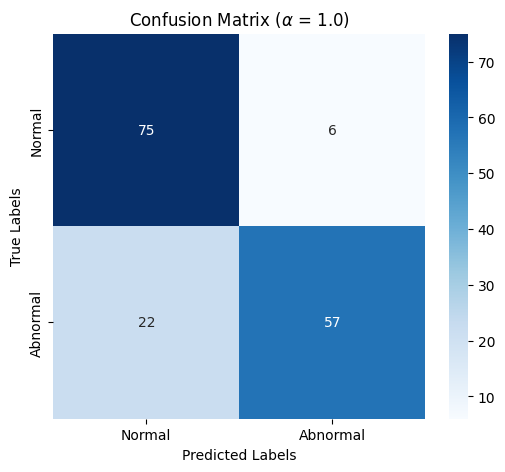

Specificity for Alpha 1.0: 0.9259
AUC Score for Alpha 1.0: 0.8995

 Evaluating fine-tuned model for alpha = 1.1...
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step
 y_true shape: (160,) | y_pred shape: (160,)
              precision    recall  f1-score   support

      Normal     0.7653    0.9259    0.8380        81
    Abnormal     0.9032    0.7089    0.7943        79

    accuracy                         0.8187       160
   macro avg     0.8343    0.8174    0.8162       160
weighted avg     0.8334    0.8187    0.8164       160



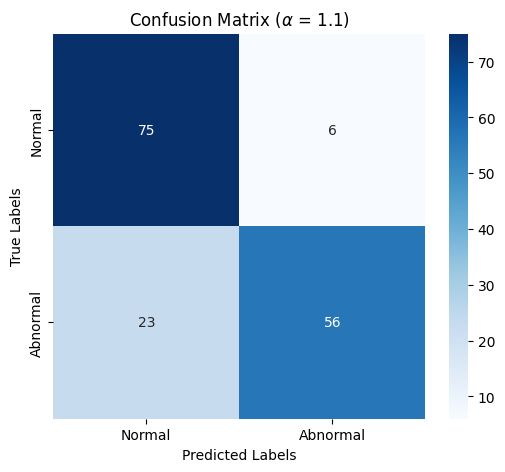

Specificity for Alpha 1.1: 0.9259
AUC Score for Alpha 1.1: 0.9231

 Evaluating fine-tuned model for alpha = 1.2...
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 448ms/step
 y_true shape: (160,) | y_pred shape: (160,)
              precision    recall  f1-score   support

      Normal     0.7917    0.9383    0.8588        81
    Abnormal     0.9219    0.7468    0.8252        79

    accuracy                         0.8438       160
   macro avg     0.8568    0.8426    0.8420       160
weighted avg     0.8560    0.8438    0.8422       160



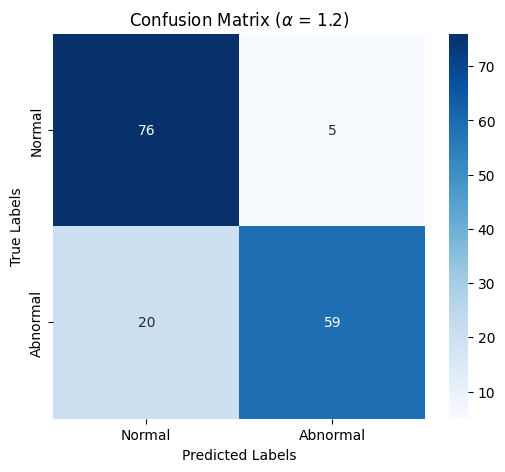

Specificity for Alpha 1.2: 0.9383
AUC Score for Alpha 1.2: 0.9244

 Evaluating fine-tuned model for alpha = 1.3...
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 397ms/step
 y_true shape: (160,) | y_pred shape: (160,)
              precision    recall  f1-score   support

      Normal     0.8571    0.9630    0.9070        81
    Abnormal     0.9565    0.8354    0.8919        79

    accuracy                         0.9000       160
   macro avg     0.9068    0.8992    0.8994       160
weighted avg     0.9062    0.9000    0.8995       160



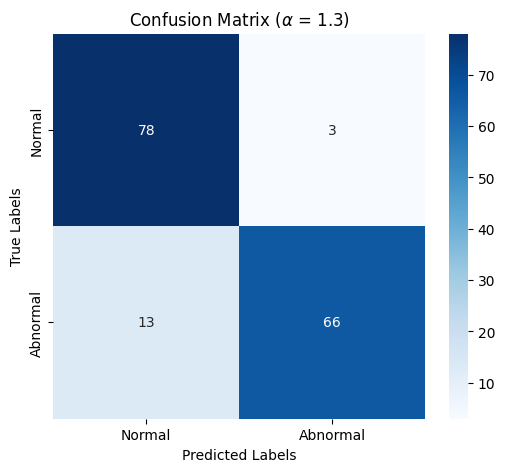

Specificity for Alpha 1.3: 0.9630
AUC Score for Alpha 1.3: 0.9544

 Evaluating fine-tuned model for alpha = 1.4...
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 397ms/step
 y_true shape: (160,) | y_pred shape: (160,)
              precision    recall  f1-score   support

      Normal     0.8837    0.9383    0.9102        81
    Abnormal     0.9324    0.8734    0.9020        79

    accuracy                         0.9062       160
   macro avg     0.9081    0.9058    0.9061       160
weighted avg     0.9078    0.9062    0.9061       160



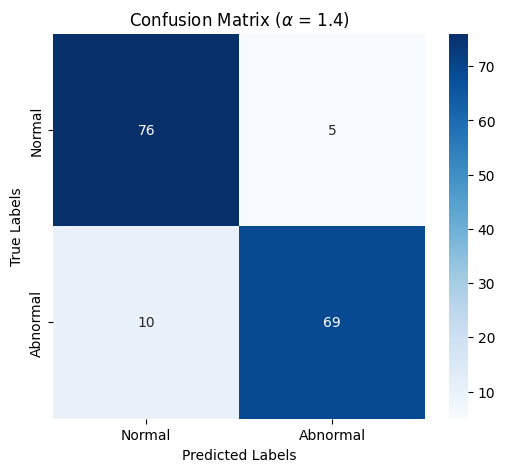

Specificity for Alpha 1.4: 0.9383
AUC Score for Alpha 1.4: 0.9556

 Evaluating fine-tuned model for alpha = 1.5...
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 465ms/step
 y_true shape: (160,) | y_pred shape: (160,)
              precision    recall  f1-score   support

      Normal     0.8764    0.9630    0.9176        81
    Abnormal     0.9577    0.8608    0.9067        79

    accuracy                         0.9125       160
   macro avg     0.9171    0.9119    0.9122       160
weighted avg     0.9166    0.9125    0.9122       160



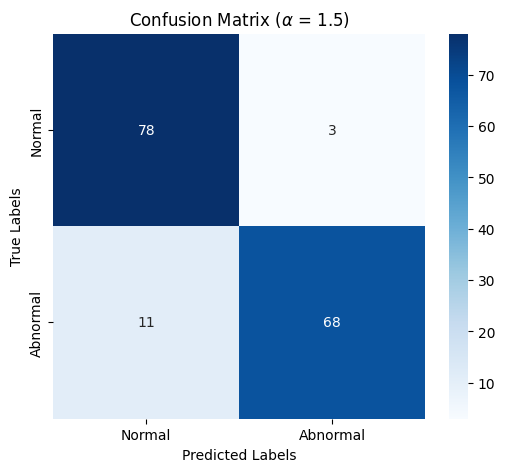

Specificity for Alpha 1.5: 0.9630
AUC Score for Alpha 1.5: 0.9556

 Evaluating fine-tuned model for alpha = 1.6...
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 412ms/step
 y_true shape: (160,) | y_pred shape: (160,)
              precision    recall  f1-score   support

      Normal     0.8571    0.9630    0.9070        81
    Abnormal     0.9565    0.8354    0.8919        79

    accuracy                         0.9000       160
   macro avg     0.9068    0.8992    0.8994       160
weighted avg     0.9062    0.9000    0.8995       160



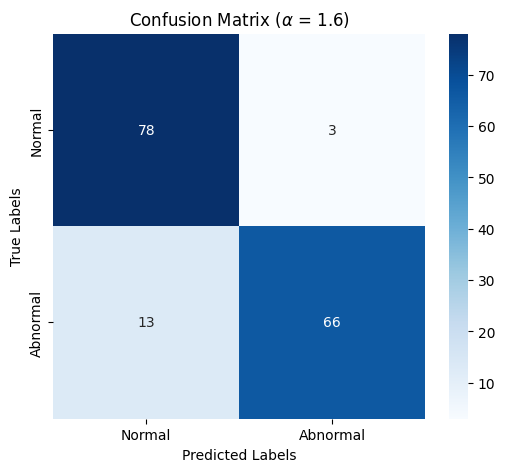

Specificity for Alpha 1.6: 0.9630
AUC Score for Alpha 1.6: 0.9609

 Evaluating fine-tuned model for alpha = 1.7...
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step
 y_true shape: (160,) | y_pred shape: (160,)
              precision    recall  f1-score   support

      Normal     0.8987    0.8765    0.8875        81
    Abnormal     0.8765    0.8987    0.8875        79

    accuracy                         0.8875       160
   macro avg     0.8876    0.8876    0.8875       160
weighted avg     0.8878    0.8875    0.8875       160



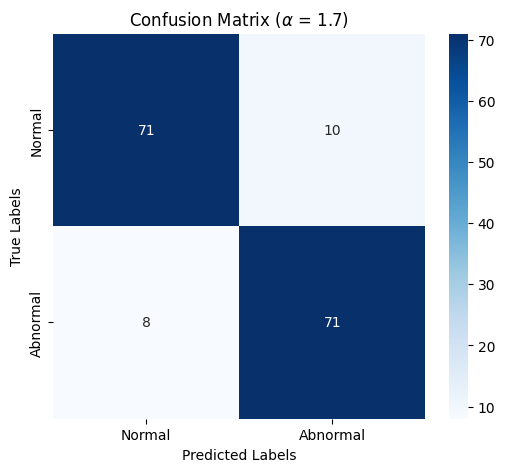

Specificity for Alpha 1.7: 0.8765
AUC Score for Alpha 1.7: 0.9522

 Evaluating fine-tuned model for alpha = 1.8...
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 401ms/step
 y_true shape: (160,) | y_pred shape: (160,)
              precision    recall  f1-score   support

      Normal     0.9577    0.8395    0.8947        81
    Abnormal     0.8539    0.9620    0.9048        79

    accuracy                         0.9000       160
   macro avg     0.9058    0.9008    0.8997       160
weighted avg     0.9065    0.9000    0.8997       160



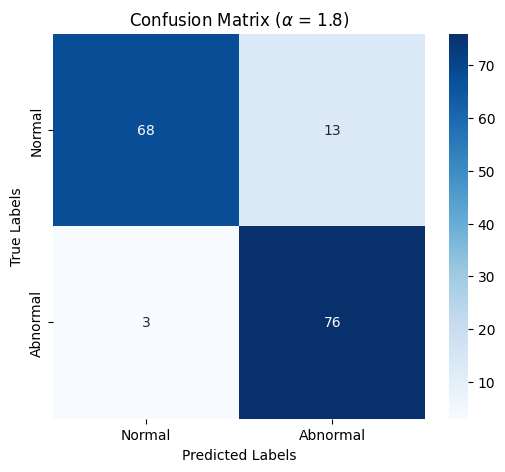

Specificity for Alpha 1.8: 0.8395
AUC Score for Alpha 1.8: 0.9594

 Evaluating fine-tuned model for alpha = 1.9...
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 414ms/step
 y_true shape: (160,) | y_pred shape: (160,)
              precision    recall  f1-score   support

      Normal     0.9359    0.9012    0.9182        81
    Abnormal     0.9024    0.9367    0.9193        79

    accuracy                         0.9187       160
   macro avg     0.9192    0.9190    0.9187       160
weighted avg     0.9194    0.9187    0.9187       160



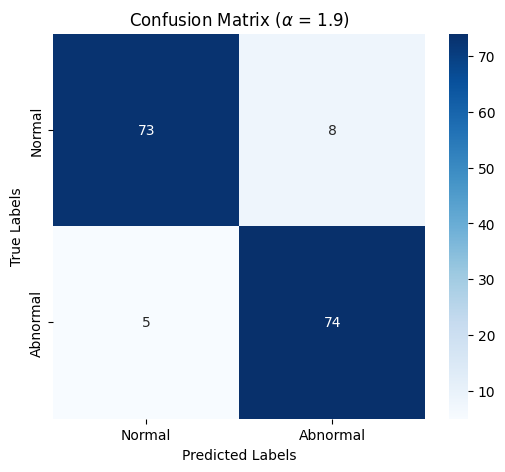

Specificity for Alpha 1.9: 0.9012
AUC Score for Alpha 1.9: 0.9562


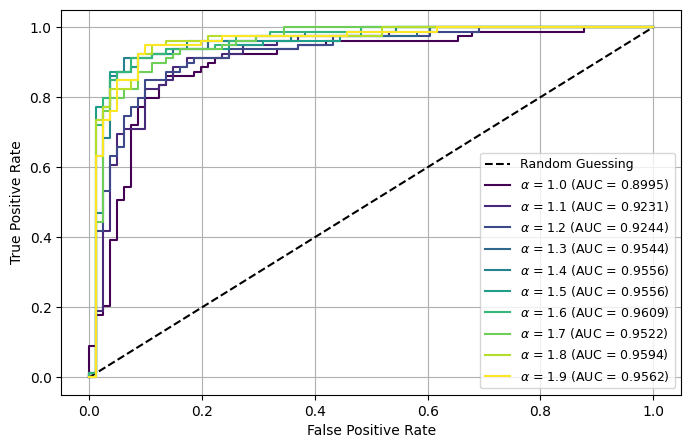

  Evaluation complete for all test images!


In [21]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

alphas = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]

# Image size
img_size = (224, 224)                                

#  Use generator’s classes instead of next()
valid_y = test_gen.classes  
print(f" Test data: {len(valid_y)} samples")

colors = plt.cm.viridis(np.linspace(0, 1, len(alphas)))
fpr_dict, tpr_dict, auc_scores = {}, {}, {}

for alpha, color in zip(alphas, colors):
    print(f"\n Evaluating fine-tuned model for alpha = {alpha}...")

    model_path = f"classification/finetune_{alpha}.keras"
    if not os.path.exists(model_path):
        print(f" Model file {model_path} not found! Skipping.")
        continue

    # Load model
    model = tf.keras.models.load_model(model_path, compile=False)

    #  Predict on entire generator
    pred_y = model.predict(test_gen, verbose=1)

    # Convert predictions to binary labels
    y_pred = (pred_y.ravel() > 0.5).astype(int)
    y_true = valid_y.ravel()

    # Confirm shapes
    print(f" y_true shape: {y_true.shape} | y_pred shape: {y_pred.shape}")

    # Classification report
    print(classification_report(
        y_true, y_pred,
        target_names=['Normal', 'Abnormal'],
        zero_division=1,
        digits=4
    ))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt='g', cmap='Blues',
        xticklabels=['Normal', 'Abnormal'],
        yticklabels=['Normal', 'Abnormal']
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix ($\\alpha$ = {alpha})")
    plt.savefig(f"Confusion_Matrix_{alpha}.png", dpi=600, bbox_inches='tight')
    plt.show()

    # Compute specificity
    TN, FP, FN, TP = cm.ravel()
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
    print(f"Specificity for Alpha {alpha}: {specificity:.4f}")
 
    # ROC curve for positive class (Abnormal)
    fpr, tpr, _ = roc_curve(y_true, pred_y.ravel())
    auc_score = auc(fpr, tpr)
    fpr_dict[alpha] = fpr
    tpr_dict[alpha] = tpr
    auc_scores[alpha] = auc_score
    print(f"AUC Score for Alpha {alpha}: {auc_score:.4f}")

# --------------------------
# FINAL ROC COMPARISON PLOT
# --------------------------
plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")

for alpha, color in zip(alphas, colors):
    if alpha in fpr_dict:
        plt.plot(fpr_dict[alpha], tpr_dict[alpha], color=color,
                 label=f"$\\alpha$ = {alpha} (AUC = {auc_scores[alpha]:.4f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize=9, frameon=True)
plt.grid(True)
plt.savefig('silicosis_ROC_Comp_Vgg19.png', dpi=600, bbox_inches='tight')
plt.show()

print("  Evaluation complete for all test images!")
